# MNIST Deformation

## 旋轉

In [1]:
import argparse
import cv2
# https://pypi.org/project/opencv-python/
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2,2)
    plt.imshow(image , cmap='binary')
    plt.show()

def image_rotate(image,angle,center=None,scale=1.0):
    # 圖片大小
    (h,w)=image.shape[:2]
    # 若未指定旋轉中心，就以圖像中心為準
    if center is None:
        center = (w/2,h/2)
    # 旋轉
    M = cv2.getRotationMatrix2D(center,angle,scale)
    rotated = cv2.warpAffine(image,M,(w,h))
    
    # 回傳以旋轉之圖像
    return rotated

## 縮放

In [150]:
def getScaleImg(img,newSize):
    resizeImg = cv2.resize(img,dsize=(newSize,newSize), interpolation = cv2.INTER_AREA)
    return resizeImg

In [103]:
def imgPosition(img,newSize,pos):
   
    resizeImg = getScaleImg(img,newSize)
    oldSize = img.shape[0]
    if pos == 1: #left up
        nImg = cv2.copyMakeBorder(resizeImg,0,oldSize-newSize,0,oldSize-newSize,cv2.BORDER_CONSTANT)
    elif pos == 2: #right up
        nImg = cv2.copyMakeBorder(resizeImg,0,oldSize-newSize,oldSize-newSize,0,cv2.BORDER_CONSTANT)
    elif pos == 3: #left down
        nImg = cv2.copyMakeBorder(resizeImg,oldSize-newSize,0,0,oldSize-newSize,cv2.BORDER_CONSTANT)
    elif pos == 4: #right down
        nImg = cv2.copyMakeBorder(resizeImg,oldSize-newSize,0,oldSize-newSize,0,cv2.BORDER_CONSTANT)
    elif pos == 5: #middle
        pad = int((oldSize-newSize)/2)
        nImg = cv2.copyMakeBorder(resizeImg,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    return nImg

pos 位置
- 1：left up
- 2：right up
- 3：left down
- 4：right down
- 5：middle

## 平移

In [4]:
def imgTranslation(img,h,v):
    H = np.float32([[1,0,h],[0,1,v]])
    rows,cols = img.shape[:2]
    nImg = cv2.warpAffine(img,H,(rows,cols))
    return nImg

- h:水平移動<br>
    舉例：向右5單位h=5；向左5單位h=-5

- v:垂直移動<br>
    舉例：向上3單位v=-3；向下3單位h=3

# CNN

## 初始化

In [5]:
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
import tensorflow as tf

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3074672994940700104, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3170070937
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 430057369386695242
 physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [7]:
# Data
(x_Train,y_Train),(x_Test,y_Test) = keras.datasets.mnist.load_data()
#多加一顏色維度
x_Train4D =x_Train.reshape(x_Train.shape[0],28,28,1).astype('float32')

# Normalization
x_Train4D = x_Train4D /255

# one hot encoding
y_TrainOneHot = to_categorical(y_Train)

## Build Model

In [67]:
from keras import layers
from keras import models

In [68]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32,
                       kernel_size = (5,5),
                        padding = 'same',
                       activation = 'relu',
                       input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters = 64,
                       kernel_size = (5,5),
                        padding = 'same',
                       activation = 'relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
# Drop 掉部分神經元，避免 overfitting
#model.add(Dropout(rate = 0.25))
model.add(layers.Dense(units=64,activation='relu'))
model.add(layers.Dense(units=10,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                200768    
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

Conv2D_1 <br>
每個 filter 有 $5*5*1$ (width,height,depth) 個 params，共有 32個 filters，故有 $5*5*32+32(bias)=832$ <br>
<br>
Conv2D_2 <br>
每個 filter 有 $5*5*32$個 params，共有 64個 filters，故有 $5*5*32*64+64(bias)=51264$ <br>
<br>
Flatten <br>
有 $7*7*64=3136$ <br>
<br>
Dense_1 <br>
有 $3136*64+64(bias)=200768$ <br>
<br>
Dense_2 <br>
有 $64*10+10(bias)=650$ <br>

In [69]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

## Train model

In [70]:
train_history = model.fit(x=x_Train4D,y= y_TrainOneHot,validation_split=0.2,epochs=50, batch_size=200,verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 11s 224us/step - loss: 0.2798 - acc: 0.9175 - val_loss: 0.0785 - val_acc: 0.9762
Epoch 2/50
48000/48000 [==============================] - 9s 192us/step - loss: 0.0666 - acc: 0.9790 - val_loss: 0.0560 - val_acc: 0.9823
Epoch 3/50
48000/48000 [==============================] - 9s 191us/step - loss: 0.0459 - acc: 0.9862 - val_loss: 0.0451 - val_acc: 0.9862
Epoch 4/50
48000/48000 [==============================] - 9s 193us/step - loss: 0.0341 - acc: 0.9897 - val_loss: 0.0392 - val_acc: 0.9877
Epoch 5/50
48000/48000 [==============================] - 9s 193us/step - loss: 0.0284 - acc: 0.9910 - val_loss: 0.0404 - val_acc: 0.9881
Epoch 6/50
48000/48000 [==============================] - 9s 193us/step - loss: 0.0232 - acc: 0.9928 - val_loss: 0.0446 - val_acc: 0.9870
Epoch 7/50
48000/48000 [==============================] - 9s 193us/step - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0407 -

In [71]:
def show_train_history(train_acc,val_acc,y_label):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[val_acc])
    plt.title('Train History')
    plt.ylabel(y_label)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

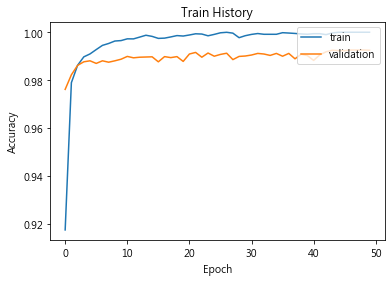

In [72]:
show_train_history('acc','val_acc','Accuracy')

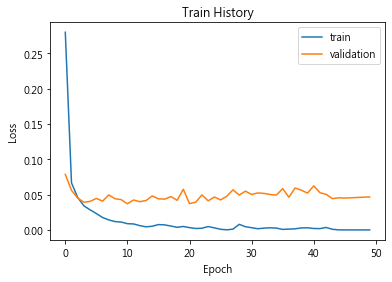

In [73]:
show_train_history('loss','val_loss','Loss')

## Test Model

## Testing Data Deformation

In [74]:
import numpy as np
import pandas as pd

In [208]:
# 旋轉 ===================================
x_Test_rotate = np.empty(x_Test.shape)

for i in range(0,x_Test.shape[0]):
    x_Test_rotate[i]=image_rotate(x_Test[i],np.random.randint(0,360))
    
# 縮放 ===================================
x_Test_sacle = np.empty(x_Test.shape)
tmp = int(x_Test.shape[1]/2)
for i in range(0,x_Test.shape[0]):
    x_Test_sacle[i] = imgPosition(x_Test[i],np.random.randint(4,tmp)*2,5)

# 縮放位移 =============================== 固定大小 14
x_Test_sacleTrans = np.empty(x_Test.shape)
tmp = int(x_Test.shape[1]/2)
for i in range(0,x_Test.shape[0]):
    x_Test_sacleTrans[i] = imgPosition(x_Test[i],tmp,np.random.randint(1,6))

# 不縮放位移 ==============================
x_Test_trans = np.empty(x_Test.shape)
for i in range(0,x_Test.shape[0]):
    x_Test_trans[i] = imgTranslation(x_Test[i],np.random.randint(-5,6),np.random.randint(-5,6))


In [190]:
def getTestData(type):
    if type == 0:
        tData = x_Test.reshape(x_Test.shape[0],28,28,1).astype('float32')
    elif type == 1 : # rotation
        tData = x_Test_rotate.reshape(x_Test_rotate.shape[0],28,28,1).astype('float32')
    elif type == 2 :
        tData = x_Test_sacle.reshape(x_Test_rotate.shape[0],28,28,1).astype('float32')
    elif type == 3 :
        tData = x_Test_sacleTrans.reshape(x_Test_rotate.shape[0],28,28,1).astype('float32')
    elif type == 4 :
        tData = x_Test_trans.reshape(x_Test_rotate.shape[0],28,28,1).astype('float32')
    
    return tData

Type
- 0：原圖
- 1：旋轉
- 2：縮放
- 3：縮放位移 
- 4：不縮放位移

In [209]:
x_Test4D = getTestData(4)

# Normalization
x_Test4D = x_Test4D  /255

# one hot encoding
y_TestOneHot = to_categorical(y_Test)

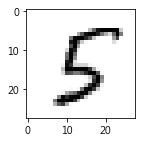

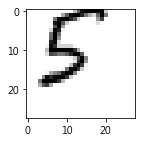

In [170]:
t = x_Test4D[23].reshape(28,28)
plot_image(t)
#t = image_rotate(t,np.random.randint(0,360))
#t = imgPosition(t,np.random.randint(4,tmp)*2,5)
#t = imgPosition(t,14,5)
t = imgTranslation(t,np.random.randint(-5,6),np.random.randint(-5,6))
plot_image(t)

In [210]:
scores = model.evaluate(x_Test4D , y_TestOneHot)
scores[1]

10000/10000 [==============================] - 1s 135us/step


0.5988

In [211]:
prediction = model.predict_classes(x_Test4D)
pd.crosstab(y_Test,prediction,
            rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,457,30,57,44,56,30,141,64,73,28
1,24,548,6,2,132,1,130,275,0,17
2,18,4,703,40,53,35,42,107,14,16
3,19,21,125,722,13,29,21,47,7,6
4,23,73,80,10,571,27,25,124,13,36
5,12,18,56,92,5,581,30,50,25,23
6,50,68,56,7,83,15,601,6,40,32
7,3,22,95,41,10,36,8,798,1,14
8,21,29,32,88,19,55,116,74,499,41
